### Chicago Crime Data Analysis

**Table of Contents**

1. Introduction to Chicago Crime Dataset
2. Dataset Setup and Loading
3. Preliminary Data Analysis
4. Data Cleaning and Preprocessing
5. Exploratory Data Analysis(EDA)
   - Crime Trend Analysis(Trend, seasonality, time series)
   - Spatial Analysis
   - Crime Type Analysis
8. Advanced Analytics and General Wrangling
9. Visualization with Pandas



#### **Introduction**

The Chicago Crime dataset is one of the most comprehensive public crime datasets available, containing reported incidents from the Chicago Police Department's CLEAR system since 2001. The dataset contains 7+ million records, from 2001 to present. It is usually updated daily (minus recent 7 days for investigation purposes). It cover all Chicago neighborhoods and it is a high-quality and standardized police records.

**Dataset Schema**

- ID - Unique identifier for the record.

- Case Number - The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.

- Date - Date when the incident occurred. this is sometimes a best estimate.

- Block - The partially redacted address where the incident occurred, placing it on the same block as the actual address.

- IUCR - The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.

- Primary Type - The primary description of the IUCR code.

- Description - The secondary description of the IUCR code, a subcategory of the primary description.

- Location Description - Description of the location where the incident occurred.

- Arrest - Indicates whether an arrest was made.

- Domestic - Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.

- Beat - Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.

- District - Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.

- Ward - The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.

- Community Area - Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

- FBI Code - Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.

- X Coordinate - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

-  Coordinate - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.

- Year - Year the incident occurred.

- Updated On - Date and time the record was last updated.

- Latitude - The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

- Longitude - The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.

- Location - The location where the incident occurred in a format that allows for creation of maps and other geographic operations on this data portal. This location is shifted from the actual location for partial redaction but falls on the same block.

**Data Source:**_https://www.kaggle.com/datasets/utkarshx27/crimes-2001-to-present?resource=download_

#### **Dataset Setup and Loading**

In [1]:
# Import the necessary libraries

#libraries for data wrangling
import pandas as pd
import numpy as np

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#libraries for time
from datetime import datetime, timedelta

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#set up views
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [2]:
# Load  the data
data_path = r"archive.zip" # I am using relative path
df = pd.read_csv(data_path, low_memory=True,compression='zip') # This is how to load zipped csv file
df.tail()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
7784659,12847575,JF420478,09/01/2022 05:00:00 AM,005XX W SURF ST,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,1934,19.0,44.0,6.0,26,1172497.0,1919410.0,2022,01/03/2023 03:46:28 PM,41.934305,-87.641485,"(41.934304581, -87.641484982)"
7784660,12847801,JF420319,07/08/2022 12:00:00 AM,114XX S PRAIRIE AVE,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,STREET,False,False,531,5.0,9.0,49.0,11,1179966.0,1828818.0,2022,01/03/2023 03:46:28 PM,41.685544,-87.616813,"(41.685543881, -87.616812541)"
7784661,12847324,JF420102,09/27/2022 11:00:00 AM,023XX E 70TH ST,0810,THEFT,OVER $500,RESIDENCE,False,False,331,3.0,5.0,43.0,06,1193181.0,1859005.0,2022,01/03/2023 03:46:28 PM,41.768068,-87.567453,"(41.768068052, -87.567452932)"
7784662,12847570,JF420427,09/03/2022 10:25:00 AM,052XX W CARMEN AVE,2021,NARCOTICS,POSSESS - BARBITURATES,RESIDENCE - YARD (FRONT / BACK),True,False,1623,16.0,45.0,11.0,18,1140553.0,1933418.0,2022,01/03/2023 03:46:28 PM,41.973391,-87.758535,"(41.973391184, -87.758534512)"
7784663,12840464,JF411839,09/26/2022 07:20:00 PM,0000X N MASON AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,SIDEWALK,True,False,1513,15.0,29.0,25.0,15,1136773.0,1899652.0,2022,01/03/2023 03:46:28 PM,41.880802,-87.773246,"(41.880802263, -87.773245737)"


In [3]:
# Lets write a function to load the full dataset (7M+ records) or just a specified samples.
# The  idea behind this is just to reduce memory usage for the dataset to also load faster.
# Take your time to understand the function, what I did and why I did so.

def load_chicago_crime_data(data_path, sample_size=None):
    """
    Optimized loading function for Chicago crime data
    """
    # Define data types to reduce memory usage
    dtype_dict = {
        'ID': 'Int32',
        'Case Number': 'string',
        'IUCR': 'category',
        'Primary Type': 'category',
        'Description': 'category',
        'Location Description': 'category',
        'Arrest': 'bool',
        'Domestic': 'bool',
        'Beat': 'Int16',
        'District': 'Int8',
        'Ward': 'Int8',
        'Community Area': 'Int8',
        'FBI Code': 'category',
        'X Coordinate': 'float32',
        'Y Coordinate': 'float32',
        'Latitude': 'float32',
        'Longitude': 'float32'
    }
    
    # Parse dates during loading
    date_cols = ['Date', 'Updated On']
    
    if sample_size:
        # Load random sample for faster analysis
        df = pd.read_csv(data_path, 
                        dtype=dtype_dict,
                        parse_dates=date_cols,
                        low_memory=False, keep_default_na=True, nrows = sample_size) # you can use ".sample(n=sample_size)" as well.
    else:
        df = pd.read_csv(data_path, 
                        dtype=dtype_dict,
                        parse_dates=date_cols,
                        low_memory=False, keep_default_na=True)
    
    return df

# I would load this and comment it out...

In [4]:
# df = load_chicago_crime_data('chicago_crime.csv', sample_size=100000)

In [5]:
df.tail()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
7784659,12847575,JF420478,09/01/2022 05:00:00 AM,005XX W SURF ST,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,1934,19.0,44.0,6.0,26,1172497.0,1919410.0,2022,01/03/2023 03:46:28 PM,41.934305,-87.641485,"(41.934304581, -87.641484982)"
7784660,12847801,JF420319,07/08/2022 12:00:00 AM,114XX S PRAIRIE AVE,1130,DECEPTIVE PRACTICE,FRAUD OR CONFIDENCE GAME,STREET,False,False,531,5.0,9.0,49.0,11,1179966.0,1828818.0,2022,01/03/2023 03:46:28 PM,41.685544,-87.616813,"(41.685543881, -87.616812541)"
7784661,12847324,JF420102,09/27/2022 11:00:00 AM,023XX E 70TH ST,0810,THEFT,OVER $500,RESIDENCE,False,False,331,3.0,5.0,43.0,06,1193181.0,1859005.0,2022,01/03/2023 03:46:28 PM,41.768068,-87.567453,"(41.768068052, -87.567452932)"
7784662,12847570,JF420427,09/03/2022 10:25:00 AM,052XX W CARMEN AVE,2021,NARCOTICS,POSSESS - BARBITURATES,RESIDENCE - YARD (FRONT / BACK),True,False,1623,16.0,45.0,11.0,18,1140553.0,1933418.0,2022,01/03/2023 03:46:28 PM,41.973391,-87.758535,"(41.973391184, -87.758534512)"
7784663,12840464,JF411839,09/26/2022 07:20:00 PM,0000X N MASON AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,SIDEWALK,True,False,1513,15.0,29.0,25.0,15,1136773.0,1899652.0,2022,01/03/2023 03:46:28 PM,41.880802,-87.773246,"(41.880802263, -87.773245737)"


Now, let's deviate a little, we can also simulate this data using numpy. 

In [6]:
# Simulating the dataset
import  numpy as np

# Lets set seed for reproducibility
np.random.seed(234)

In [7]:

# Lets write a function to  create a simulated dataset

def simulated_crime_data(n_records=10000):
    
    
    # Crime types based on actual Chicago data
    crime_types = ['THEFT', 'BATTERY', 'CRIMINAL DAMAGE', 'NARCOTICS', 
                   'ASSAULT', 'BURGLARY', 'MOTOR VEHICLE THEFT', 'ROBBERY',
                   'DECEPTIVE PRACTICE', 'CRIMINAL TRESPASS']
    
    locations = ['STREET', 'RESIDENCE', 'APARTMENT', 'SIDEWALK', 'PARKING LOT',
                'RETAIL STORE', 'SCHOOL', 'RESTAURANT', 'VEHICLE', 'OFFICE']
    
    # Generate sample data
    data = {
        'ID': range(1, n_records + 1),
        'Date': pd.date_range('2020-01-01', '2024-12-31', periods=n_records),
        'Primary Type': np.random.choice(crime_types, n_records, 
                                       p=[0.25, 0.15, 0.12, 0.10, 0.08, 0.08, 0.07, 0.05, 0.05, 0.05]),
        'Location Description': np.random.choice(locations, n_records),
        'Arrest': np.random.choice([True, False], n_records, p=[0.2, 0.8]),
        'Domestic': np.random.choice([True, False], n_records, p=[0.1, 0.9]),
        'District': np.random.randint(1, 26, n_records),
        'Ward': np.random.randint(1, 51, n_records),
        'Community Area': np.random.randint(1, 78, n_records),
        'Latitude': np.random.uniform(41.6, 42.1, n_records),
        'Longitude': np.random.uniform(-87.9, -87.5, n_records)
    }
    
    return pd.DataFrame(data)

# YOu can comment it out once you are done experimenting with it.

In [8]:
simulated = simulated_crime_data(50000)
print(f"This dataset has {len(df)} records")
simulated.head()

This dataset has 7784664 records


,ID,Date,Primary Type,Location Description,Arrest,Domestic,District,Ward,Community Area,Latitude,Longitude
0,1,2020-01-01 00:00:00.000000000,THEFT,RESTAURANT,False,True,19,20,74,41.855383,-87.570024
1,2,2020-01-01 00:52:35.391107822,BATTERY,PARKING LOT,False,False,13,19,21,41.814159,-87.677279
2,3,2020-01-01 01:45:10.782215644,DECEPTIVE PRACTICE,APARTMENT,False,False,17,45,7,41.634583,-87.837613
3,4,2020-01-01 02:37:46.173323466,CRIMINAL TRESPASS,SCHOOL,False,False,14,32,65,41.850561,-87.575418
4,5,2020-01-01 03:30:21.564431288,THEFT,SIDEWALK,False,False,22,37,9,41.690692,-87.848674


The dataset above is not as exact as the actual dataset, but it should be enough to simulate the idea of crime distribution if you dont have the actual dataset.
Lets go back to the real dataset now.

#### **Preliminary Data Analysis (PDA)**


In [9]:
# Lets resume back with our original dataset which we have denoted as "df"
# Dataset shape and basic info

print("=== DATASET OVERVIEW ===")
print(f"Dataset Shape: {df.shape}")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n=== COLUMN INFORMATION ===")
print(f"List of columns:{df.columns}")
print("")
print(f"Column details:{df.info()}")
print("\n=== FIRST AND LAST 5 RECORDS ===")
print(df.head())
print("")
print(df.tail())

print("\n=== BASIC STATISTICS ===")
print(df.describe(include='all'))

# Always ensure to understand the outputs and their corresponding codes.

=== DATASET OVERVIEW ===
Dataset Shape: (7784664, 22)
Memory Usage: 5896.10 MB

=== COLUMN INFORMATION ===
List of columns:Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7784664 entries, 0 to 7784663
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   ID                    int64  
 1   Case Number           object 
 2   Date                  object 
 3   Block                 object 
 4   IUCR                  object 
 5   Primary Type          object 
 6   Description           object 
 7   Location Description  object 
 8   Arrest                bool   
 9   Domestic              bool   
 10  Beat                  int64  
 11  Distric

**Missing Data Analysis**

- Lets write function to analyze missing values

- Check out the following and understand their usage

```
df.isna()
df.isnull()
df.empty
df.isna().sum()
df.isna().any()
```

In [10]:

def analyze_missing_data(df):
    import matplotlib.pyplot as plt
    
    """Analyze missing data patterns"""
    
    missing_data = pd.DataFrame({
        'Column': df.columns,
        'Missing_Count': df.isnull().sum(),
        'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
        'Data_Type': df.dtypes
    })
    
    missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)
    
    print("=== MISSING DATA ANALYSIS ===")
    print(missing_data)
    
    # Visualize missing data
    plt.figure(figsize=(12, 6))
    if not missing_data.empty:
        plt.bar(missing_data['Column'], missing_data['Missing_Percentage'])
        plt.title('Missing Data by Column')
        plt.xlabel('Columns')
        plt.ylabel('Missing Percentage (%)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("No missing data found!")

=== MISSING DATA ANALYSIS ===
                                    Column  Missing_Count  Missing_Percentage Data_Type
Ward                                  Ward         614848            7.898196   float64
Community Area              Community Area         613476            7.880571   float64
Longitude                        Longitude          86848            1.115629   float64
Latitude                          Latitude          86848            1.115629   float64
X Coordinate                  X Coordinate          86848            1.115629   float64
Y Coordinate                  Y Coordinate          86848            1.115629   float64
Location                          Location          86848            1.115629    object
Location Description  Location Description          10381            0.133352    object
District                          District             47            0.000604   float64
Case Number                    Case Number              4            0.000051    object


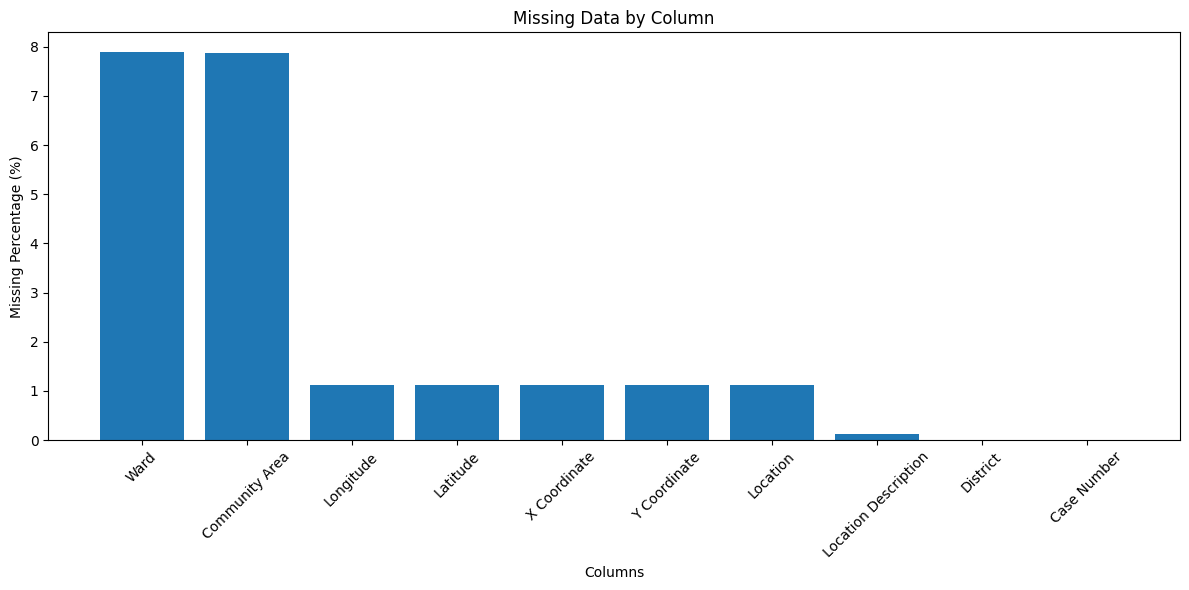

In [11]:
analyze_missing_data(df)

**Crime Distribution Overview**
 - Lets check the distrutions of crimes. But not that the print statement with multiple equal symbols has no meaning it is add for formating.

In [12]:
df["Primary Type"]

0                     BATTERY
1                       THEFT
2                       THEFT
3                   NARCOTICS
4                     ASSAULT
                  ...        
7784659         OTHER OFFENSE
7784660    DECEPTIVE PRACTICE
7784661                 THEFT
7784662             NARCOTICS
7784663     WEAPONS VIOLATION
Name: Primary Type, Length: 7784664, dtype: object

In [13]:
# Crime type distribution
print("=== CRIME TYPE DISTRIBUTION ===")
crime_counts = df['Primary Type'].value_counts()
print(crime_counts)

=== CRIME TYPE DISTRIBUTION ===
Primary Type
THEFT                                1642148
BATTERY                              1422913
CRIMINAL DAMAGE                       887266
NARCOTICS                             747633
ASSAULT                               507296
OTHER OFFENSE                         483642
BURGLARY                              424397
MOTOR VEHICLE THEFT                   375495
DECEPTIVE PRACTICE                    344940
ROBBERY                               292334
CRIMINAL TRESPASS                     214316
WEAPONS VIOLATION                     106418
PROSTITUTION                           69840
OFFENSE INVOLVING CHILDREN             55719
PUBLIC PEACE VIOLATION                 52325
SEX OFFENSE                            30683
CRIM SEXUAL ASSAULT                    27631
INTERFERENCE WITH PUBLIC OFFICER       18392
LIQUOR LAW VIOLATION                   14901
GAMBLING                               14618
ARSON                                  13249
HOMICIDE  

In [14]:
# Top 10 crime types
print("\n=== TOP 7 CRIME TYPES ===")
top_crimes = crime_counts.head(7)
print(top_crimes)


=== TOP 7 CRIME TYPES ===
Primary Type
THEFT              1642148
BATTERY            1422913
CRIMINAL DAMAGE     887266
NARCOTICS           747633
ASSAULT             507296
OTHER OFFENSE       483642
BURGLARY            424397
Name: count, dtype: int64


In [15]:
# Arrest rate analysis
arrest_rate = df['Arrest'].mean() * 100
print(f"\n=== OVERALL ARREST RATE ===")
print(f"Overall Arrest Rate: {arrest_rate:.2f}%")


=== OVERALL ARREST RATE ===
Overall Arrest Rate: 26.14%


In [16]:
# Domestic violence rate
domestic_rate = df['Domestic'].mean() * 100
print(f"Domestic Violence Rate: {domestic_rate:.2f}%")

Domestic Violence Rate: 13.83%


### **Data Cleaning and Preprocessing**

- Lets extract the relevant data from the datetime data.

In [17]:
df.Date
# This is what the date column looks like, the date is recorded in timestamp, So it is easy to extract other data components from it.

0          09/05/2015 01:30:00 PM
1          09/04/2015 11:30:00 AM
2          09/01/2018 12:01:00 AM
3          09/05/2015 12:45:00 PM
4          09/05/2015 01:00:00 PM
                    ...          
7784659    09/01/2022 05:00:00 AM
7784660    07/08/2022 12:00:00 AM
7784661    09/27/2022 11:00:00 AM
7784662    09/03/2022 10:25:00 AM
7784663    09/26/2022 07:20:00 PM
Name: Date, Length: 7784664, dtype: object

In [18]:
# Lets check the data type to be sure its in pandas `datetime` format
print(df['Date'].dtype) # --> check the output
print(type(df['Date'][0])) # --> also check the output

# if not we can used this to convert the date column to datetime

# df['Date'] = pd.to_datetime(df['Date'])

object
<class 'str'>


In [19]:
def extract_date_features(df):
    """This function will extract useful date features from the Date column"""
    df = df.copy()
    
    # Ensure Date is datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Extract date components
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['Hour'] = df['Date'].dt.hour
    df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
    df['Day_Name'] = df['Date'].dt.day_name()
    df['Month_Name'] = df['Date'].dt.month_name()
    df['Quarter'] = df['Date'].dt.quarter
    df['Is_Weekend'] = df['Day_of_Week'].isin([5, 6])  # Saturday, Sunday
    
    # Time periods
    df['Time_Period'] = pd.cut(df['Hour'], 
                              bins=[0, 6, 12, 18, 24], 
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                              include_lowest=True)
    
    return df

In [20]:

# Apply date feature extraction
df = extract_date_features(df)
print("Date features extracted successfully!")
print(f"New columns: {['Year', 'Month', 'Hour', 'Day_of_Week', 'Day_Name', 'Is_Weekend', 'Time_Period']}")

Date features extracted successfully!
New columns: ['Year', 'Month', 'Hour', 'Day_of_Week', 'Day_Name', 'Is_Weekend', 'Time_Period']


In [21]:
print(df.columns)
# Explore the output

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Day_of_Week', 'Day_Name', 'Month_Name', 'Quarter', 'Is_Weekend', 'Time_Period'], dtype='object')


Now that we have extracted all the neccessary components from our date column, lets create a pipeline for data cleaning.

**Data Cleaning Pipeline**

In [22]:
print(f"Numbers of unique crime types: {len(df['Primary Type'].unique())}")

# We can also use this to check the number of unique values in a column
print(f"This also works: {(df['Primary Type'].nunique())}")

# Lets view the list of unique crrime types
print(df['Primary Type'].unique())

Numbers of unique crime types: 36
This also works: 36
['BATTERY' 'THEFT' 'NARCOTICS' 'ASSAULT' 'BURGLARY' 'ROBBERY'
 'DECEPTIVE PRACTICE' 'OTHER OFFENSE' 'CRIMINAL DAMAGE'
 'WEAPONS VIOLATION' 'CRIMINAL TRESPASS' 'MOTOR VEHICLE THEFT'
 'SEX OFFENSE' 'INTERFERENCE WITH PUBLIC OFFICER'
 'OFFENSE INVOLVING CHILDREN' 'PUBLIC PEACE VIOLATION' 'PROSTITUTION'
 'GAMBLING' 'CRIM SEXUAL ASSAULT' 'LIQUOR LAW VIOLATION'
 'CRIMINAL SEXUAL ASSAULT' 'ARSON' 'STALKING' 'KIDNAPPING' 'INTIMIDATION'
 'CONCEALED CARRY LICENSE VIOLATION' 'NON - CRIMINAL' 'HUMAN TRAFFICKING'
 'OBSCENITY' 'PUBLIC INDECENCY' 'OTHER NARCOTIC VIOLATION' 'NON-CRIMINAL'
 'HOMICIDE' 'NON-CRIMINAL (SUBJECT SPECIFIED)' 'RITUALISM'
 'DOMESTIC VIOLENCE']


In [23]:
# LEts view for latitude and longitude
print(f"Minimum latitude: {df['Latitude'].min()}")
print(f"Maximum latitude: {df['Latitude'].max()}")
print(f"Minimum longitude: {df['Longitude'].min()}")
print(f"Maximum longitude: {df['Longitude'].max()}")

Minimum latitude: 36.619446395
Maximum latitude: 42.022910333
Minimum longitude: -91.686565684
Maximum longitude: -87.524529378


In [24]:
# Lets view for District and Ward
print(f"Minimum District: {df['District'].min()}")
print(f"Maximum District: {df['District'].max()}")
print(f"Minimum Ward: {df['Ward'].min()}")
print(f"Maximum Ward: {df['Ward'].max()}")

Minimum District: 1.0
Maximum District: 31.0
Minimum Ward: 1.0
Maximum Ward: 50.0


In [25]:
def clean_crime_data(df):
    """ data cleaning pipeline"""
    df_clean = df.copy()
    
    print("=== DATA CLEANING PIPELINE ===")
    print(f"Initial records: {len(df_clean)}")
    
    # 1. Remove records with important missing  information
    initial_count = len(df_clean)
    df_clean = df_clean.dropna(subset=['Date', 'Primary Type'])
    print(f"After removing null dates/crime types: {len(df_clean)} (-{initial_count - len(df_clean)})")
    
    # 2. Remove invalid coordinates
    initial_count = len(df_clean)
    df_clean = df_clean[
        (df_clean['Latitude'].between(41.6, 42.1)) & 
        (df_clean['Longitude'].between(-87.9, -87.5))
    ]
    print(f"After removing invalid coordinates: {len(df_clean)} (-{initial_count - len(df_clean)})")
    
    # 3. Standardize text fields
    text_columns = ['Primary Type', 'Location Description']
    for col in text_columns:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].str.upper().str.strip()
    
    # 4. Handle outliers in district/ward
    df_clean = df_clean[
        (df_clean['District'].between(1, 25)) & 
        (df_clean['Ward'].between(1, 50))
    ]
    
    print(f"Final cleaned records: {len(df_clean)}")
    print("Data cleaning completed!")
    
    return df_clean

In [26]:
# Lets apply cleaning
df_clean = clean_crime_data(df)

=== DATA CLEANING PIPELINE ===
Initial records: 7784664
After removing null dates/crime types: 7784664 (-0)
After removing invalid coordinates: 7671881 (-112783)
Final cleaned records: 7068429
Data cleaning completed!


**Data Quality Validation**

In [27]:
def validate_data_quality(df):
    
    """Validate data quality after cleaning"""
    
    print(":::::::::: DATA QUALITY VALIDATION :::::::::::")
    
    # Date range validation
    date_range = f"{df['Date'].min()} to {df['Date'].max()}"
    print(f"Date Range: {date_range}")
    
    # Coordinate validation
    coord_valid = ((df['Latitude'].between(41.6, 42.1)) & 
                   (df['Longitude'].between(-87.9, -87.5))).all()
    print(f"Coordinates Valid: {coord_valid}")
    
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(f"Duplicate Records: {duplicates}")
    
    # Crime type consistency
    unique_crimes = df['Primary Type'].nunique()
    print(f"Unique Crime Types: {unique_crimes}")
    
    # Missing critical fields
    critical_missing = df[['Date', 'Primary Type', 'Latitude', 'Longitude']].isnull().sum()
    print(f"Missing Critical Fields:\n{critical_missing}")
    
    print("Data quality validation completed!")

In [28]:
validate_data_quality(df_clean)

:::::::::: DATA QUALITY VALIDATION :::::::::::
Date Range: 2001-01-01 00:00:00 to 2023-04-21 23:59:00
Coordinates Valid: True
Duplicate Records: 0
Unique Crime Types: 35
Missing Critical Fields:
Date            0
Primary Type    0
Latitude        0
Longitude       0
dtype: int64
Data quality validation completed!


#### **Exploratory Data Analysis**


**Trend Analysis**

In [29]:
def analyze_trends(df):
    
    """trend analysis"""
    
    # 1. Yearly trends
    print("=== YEARLY CRIME TRENDS ===")
    yearly_crimes = df.groupby('Year').size()
    print(yearly_crimes)
    
    # 2. Monthly patterns
    print("\n=== MONTHLY CRIME PATTERNS ===")
    monthly_crimes = df.groupby('Month_Name').size().reindex([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])
    print(monthly_crimes)
    
    # 3. Daily patterns
    print("\n=== DAILY CRIME PATTERNS ===")
    daily_crimes = df.groupby('Day_Name').size().reindex([
        'Monday', 'Tuesday', 'Wednesday', 'Thursday', 
        'Friday', 'Saturday', 'Sunday'
    ])
    print(daily_crimes)
    
    # 4. Hourly patterns
    print("\n=== HOURLY CRIME PATTERNS ===")
    hourly_crimes = df.groupby('Hour').size()
    print(hourly_crimes)
    
    # 5. Weekend vs Weekday
    print("\n=== WEEKEND VS WEEKDAY ===")
    weekend_analysis = df.groupby('Is_Weekend').agg({
        'ID': 'count',
        'Arrest': 'mean',
        'Domestic': 'mean'
    }).round(3)
    weekend_analysis.index = ['Weekday', 'Weekend']
    print(weekend_analysis)
    
    return {
        'yearly': yearly_crimes,
        'monthly': monthly_crimes, 
        'daily': daily_crimes,
        'hourly': hourly_crimes
    }

In [30]:
# Lets apply the function to analyze trend

temporal_data = analyze_trends(df_clean)

=== YEARLY CRIME TRENDS ===
Year
2001      3885
2002    343949
2003    470679
2004    465912
2005    448697
2006    443717
2007    434014
2008    418429
2009    384681
2010    368988
2011    350177
2012    334437
2013    305146
2014    272562
2015    257048
2016    266344
2017    264091
2018    262602
2019    258254
2020    207937
2021    202157
2022    232253
2023     72470
dtype: int64

=== MONTHLY CRIME PATTERNS ===
Month_Name
January      537360
February     474737
March        566099
April        568502
May          634155
June         631980
July         664287
August       657454
September    618637
October      623458
November     559970
December     531790
dtype: int64

=== DAILY CRIME PATTERNS ===
Day_Name
Monday        997688
Tuesday      1009006
Wednesday    1015866
Thursday     1004926
Friday       1062388
Saturday     1013784
Sunday        964771
dtype: int64

=== HOURLY CRIME PATTERNS ===
Hour
0     397814
1     225161
2     190400
3     154206
4     117032
5      97452


**Seasonal Analysis**
- We will analyse seasonality here

In [31]:
def analyze_seasonality(df):
    
    """Analyze seasonal crime patterns"""
    
    # Define seasons
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    df['Season'] = df['Month'].apply(get_season)
    
    # Seasonal crime analysis
    seasonal_crimes = df.groupby(['Season', 'Primary Type']).size().unstack(fill_value=0)
    
    print("=== SEASONAL CRIME ANALYSIS ===")
    print("Top 5 crimes by season:")
    for season in ['Spring', 'Summer', 'Fall', 'Winter']:
        print(f"\n{season}:")
        season_total = seasonal_crimes.loc[season].sort_values(ascending=False)
        print(season_total.head())
    print("Crime seasonal analysis completed!")
    return seasonal_crimes


In [32]:
seasonal_data = analyze_seasonality(df_clean)

=== SEASONAL CRIME ANALYSIS ===
Top 5 crimes by season:

Spring:
Primary Type
THEFT              353361
BATTERY            339158
CRIMINAL DAMAGE    207580
NARCOTICS          172611
ASSAULT            122024
Name: Spring, dtype: int64

Summer:
Primary Type
THEFT              427079
BATTERY            373384
CRIMINAL DAMAGE    227542
NARCOTICS          169214
ASSAULT            132164
Name: Summer, dtype: int64

Fall:
Primary Type
THEFT              391157
BATTERY            319241
CRIMINAL DAMAGE    211314
NARCOTICS          166245
ASSAULT            116238
Name: Fall, dtype: int64

Winter:
Primary Type
THEFT              320745
BATTERY            266614
CRIMINAL DAMAGE    164589
NARCOTICS          159176
OTHER OFFENSE      103691
Name: Winter, dtype: int64
Crime seasonal analysis completed!


**Time Series Analysis**


In [33]:
def time_series_analysis(df):
    """time series analysis"""
    
    # Daily crime counts
    daily_ts = df.groupby(df['Date'].dt.date).size()
    daily_ts.index = pd.to_datetime(daily_ts.index)
    
    # Monthly aggregation
    monthly_ts = df.groupby(df['Date'].dt.to_period('M')).size()
    
    # Calculate rolling averages
    daily_ts_7day = daily_ts.rolling(window=7).mean()
    daily_ts_30day = daily_ts.rolling(window=30).mean()
    
    print("=== TIME SERIES STATISTICS ===")
    print(f"Daily Crime Average: {daily_ts.mean():.2f}")
    print(f"Daily Crime Std: {daily_ts.std():.2f}")
    print(f"Highest Crime Day: {daily_ts.idxmax()} ({daily_ts.max()} crimes)")
    print(f"Lowest Crime Day: {daily_ts.idxmin()} ({daily_ts.min()} crimes)")
    print(f"Monthly Crime Average: {monthly_ts.mean():.2f}")
    print(f"Monthly Crime Std: {monthly_ts.std():.2f}")
    print(f"Highest Crime Month: {monthly_ts.idxmax()} ({monthly_ts.max()} crimes)")
    print(f"Lowest Crime Month: {monthly_ts.idxmin()} ({monthly_ts.min()} crimes)")
    
    print("Time series analysis completed!")
    return {
        'daily': daily_ts,
        'monthly': monthly_ts,
        'daily_7day_ma': daily_ts_7day,
        'daily_30day_ma': daily_ts_30day,
        
        
    }

In [34]:
ts_data = time_series_analysis(df_clean)

=== TIME SERIES STATISTICS ===
Daily Crime Average: 868.04
Daily Crime Std: 339.20
Highest Crime Day: 2020-05-31 00:00:00 (1894 crimes)
Lowest Crime Day: 2001-01-07 00:00:00 (1 crimes)
Monthly Crime Average: 26374.74
Monthly Crime Std: 10141.19
Highest Crime Month: 2002-07 (44836 crimes)
Lowest Crime Month: 2001-02 (166 crimes)
Time series analysis completed!


#### **Spatial Analysis**

**Geograpic Distribution**


In [35]:
def analyze_spatial_patterns(df):
    """spatial analysis"""
    
    # 1. District analysis
    print("=== CRIME BY DISTRICT ===")
    district_crimes = df.groupby('District').agg({
        'ID': 'count',
        'Arrest': 'mean',
        'Domestic': 'mean',
        'Primary Type': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'Unknown'
    }).round(3)
    district_crimes.columns = ['Total_Crimes', 'Arrest_Rate', 'Domestic_Rate', 'Most_Common_Crime']
    district_crimes = district_crimes.sort_values('Total_Crimes', ascending=False)
    print(district_crimes.head(10))
    
    # 2. Ward analysis
    print("\n=== TOP 10 WARDS BY CRIME COUNT ===")
    ward_crimes = df['Ward'].value_counts().head(10)
    print(ward_crimes)
    
    # 3. Community area analysis
    print("\n=== TOP 10 COMMUNITY AREAS BY CRIME COUNT ===")
    community_crimes = df['Community Area'].value_counts().head(10)
    print(community_crimes)
    
    # 4. Location type analysis
    print("\n=== CRIMES BY LOCATION TYPE ===")
    location_crimes = df['Location Description'].value_counts().head(10)
    print(location_crimes)
    
    print("Spatial analysis completed!")
    return district_crimes

In [36]:
spatial_data = analyze_spatial_patterns(df_clean)

=== CRIME BY DISTRICT ===
          Total_Crimes  Arrest_Rate  Domestic_Rate Most_Common_Crime
District                                                            
8.0             479306        0.225          0.145             THEFT
11.0            457597        0.415          0.154         NARCOTICS
6.0             419384        0.257          0.191           BATTERY
7.0             412834        0.280          0.201           BATTERY
4.0             406672        0.224          0.160           BATTERY
25.0            403259        0.270          0.157             THEFT
3.0             361056        0.254          0.208           BATTERY
12.0            349637        0.221          0.096             THEFT
9.0             346081        0.274          0.129           BATTERY
2.0             321880        0.246          0.137             THEFT

=== TOP 10 WARDS BY CRIME COUNT ===
Ward
28.0    325143
42.0    294718
24.0    277690
27.0    266680
2.0     252150
6.0     235069
17.0    235000

**Crime Hotspot Analysis**


In [37]:
def identify_hotspots(df, grid_size=0.01):
    """Identify crime hotspots using grid-based analysis"""
    
    # Create spatial grid
    lat_bins = np.arange(df['Latitude'].min(), df['Latitude'].max() + grid_size, grid_size)
    lon_bins = np.arange(df['Longitude'].min(), df['Longitude'].max() + grid_size, grid_size)
    
    # Bin coordinates
    df['lat_bin'] = pd.cut(df['Latitude'], lat_bins, include_lowest=True)
    df['lon_bin'] = pd.cut(df['Longitude'], lon_bins, include_lowest=True)
    
    # Count crimes per grid cell
    hotspots = df.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='crime_count')
    hotspots = hotspots.sort_values('crime_count', ascending=False)
    
    print("=== TOP 10 CRIME HOTSPOTS ===")
    print(hotspots.head(10))
    
    # Calculate hotspot statistics
    print(f"\n=== HOTSPOT STATISTICS ===")
    print(f"Total grid cells: {len(hotspots)}")
    print(f"Average crimes per cell: {hotspots['crime_count'].mean():.2f}")
    print(f"Max crimes in single cell: {hotspots['crime_count'].max()}")
    print("Hotspot analysis completed!")
    return hotspots

In [38]:
hotspots = identify_hotspots(df_clean)

=== TOP 10 CRIME HOTSPOTS ===
              lat_bin           lon_bin  crime_count
901  (41.875, 41.885]  (-87.63, -87.62]        76907
939  (41.885, 41.895]  (-87.63, -87.62]        69611
977  (41.895, 41.905]  (-87.63, -87.62]        57759
409  (41.745, 41.755]   (-87.61, -87.6]        56504
891  (41.875, 41.885]  (-87.73, -87.72]        50491
888  (41.875, 41.885]  (-87.76, -87.75]        44578
522  (41.775, 41.785]  (-87.62, -87.61]        44267
967  (41.895, 41.905]  (-87.73, -87.72]        43426
890  (41.875, 41.885]  (-87.74, -87.73]        43284
889  (41.875, 41.885]  (-87.75, -87.74]        42948

=== HOTSPOT STATISTICS ===
Total grid cells: 1444
Average crimes per cell: 4895.03
Max crimes in single cell: 76907
Hotspot analysis completed!


**Crime Type Analysis**

- Detailed Crime Analysis

In [39]:
def analyze_crime_types(df):
    """Comprehensive crime type analysis"""
    
    # 1. Overall crime distribution
    crime_dist = df['Primary Type'].value_counts()
    crime_pct = (crime_dist / len(df) * 100).round(2)
    
    crime_summary = pd.DataFrame({
        'Count': crime_dist,
        'Percentage': crime_pct
    })
    
    print("=== CRIME TYPE DISTRIBUTION ===")
    print(crime_summary.head(10))
    
    # 2. Arrest rates by crime type
    print("\n=== ARREST RATES BY CRIME TYPE ===")
    arrest_rates = df.groupby('Primary Type')['Arrest'].agg(['count', 'mean']).round(3)
    arrest_rates.columns = ['Total_Cases', 'Arrest_Rate']
    arrest_rates = arrest_rates.sort_values('Arrest_Rate', ascending=False)
    print(arrest_rates.head(10))
    
    # 3. Domestic violence by crime type
    print("\n=== DOMESTIC VIOLENCE RATES BY CRIME TYPE ===")
    domestic_rates = df.groupby('Primary Type')['Domestic'].agg(['count', 'mean']).round(3)
    domestic_rates.columns = ['Total_Cases', 'Domestic_Rate']
    domestic_rates = domestic_rates[domestic_rates['Domestic_Rate'] > 0].sort_values('Domestic_Rate', ascending=False)
    print(domestic_rates.head(10))
    
    print("Crime type analysis completed!")
    return crime_summary, arrest_rates, domestic_rates

In [40]:
crime_analysis = analyze_crime_types(df_clean)

=== CRIME TYPE DISTRIBUTION ===
                       Count  Percentage
Primary Type                            
THEFT                1492342       21.11
BATTERY              1298397       18.37
CRIMINAL DAMAGE       811025       11.47
NARCOTICS             667246        9.44
ASSAULT               465145        6.58
OTHER OFFENSE         435611        6.16
BURGLARY              390494        5.52
MOTOR VEHICLE THEFT   339144        4.80
DECEPTIVE PRACTICE    307155        4.35
ROBBERY               267971        3.79

=== ARREST RATES BY CRIME TYPE ===
                                   Total_Cases  Arrest_Rate
Primary Type                                               
PROSTITUTION                             61349        0.996
NARCOTICS                               667246        0.994
GAMBLING                                 13404        0.993
LIQUOR LAW VIOLATION                     12782        0.991
PUBLIC INDECENCY                           182        0.989
CONCEALED CARRY LICE

**Crime Correlation Analysis**

In [41]:
def crime_correlation_analysis(df):
    """Analyze correlations between different crime factors"""
    
    # Create crime type dummies for correlation analysis
    crime_dummies = pd.get_dummies(df['Primary Type'], prefix='crime')
    
    # Combine with other features
    correlation_df = pd.concat([
        df[['Hour', 'District', 'Ward', 'Is_Weekend', 'Arrest', 'Domestic']],
        crime_dummies
    ], axis=1)
    
    # Calculate correlations
    correlations = correlation_df.corr()
    
    print("=== CRIME CORRELATIONS ===")
    print("Top positive correlations with arrests:")
    arrest_corr = correlations['Arrest'].sort_values(ascending=False)
    print(arrest_corr.head(10))
    
    print("\nTop positive correlations with domestic violence:")
    domestic_corr = correlations['Domestic'].sort_values(ascending=False)
    print(domestic_corr.head(10))
    
    print("Correlation analysis completed!")
    return correlations

In [42]:
correlations = crime_correlation_analysis(df_clean)

=== CRIME CORRELATIONS ===
Top positive correlations with arrests:
Arrest                                    1.000000
crime_NARCOTICS                           0.542227
crime_CRIMINAL TRESPASS                   0.165991
crime_PROSTITUTION                        0.157555
crime_WEAPONS VIOLATION                   0.131266
Hour                                      0.081956
crime_INTERFERENCE WITH PUBLIC OFFICER    0.076434
crime_PUBLIC PEACE VIOLATION              0.074835
crime_GAMBLING                            0.073134
crime_LIQUOR LAW VIOLATION                0.071168
Name: Arrest, dtype: float64

Top positive correlations with domestic violence:
Domestic                                  1.000000
crime_BATTERY                             0.416190
crime_OTHER OFFENSE                       0.122170
crime_OFFENSE INVOLVING CHILDREN          0.097864
crime_ASSAULT                             0.067967
Is_Weekend                                0.043617
crime_STALKING                       

#### **Advanced Analytics**

- Crime Pattern Minning

In [43]:
def analyze_crime_patterns(df):
    """Advanced pattern analysis"""
    
    # 1. Crime sequence patterns
    print("=== CRIME SEQUENCE PATTERNS ===")
    
    # Group crimes by location and analyze sequences
    location_sequences = df.groupby(['District', 'Primary Type']).size().unstack(fill_value=0)
    
    # Find districts with unusual crime patterns
    print("Districts with highest crime diversity:")
    crime_diversity = (location_sequences > 0).sum(axis=1).sort_values(ascending=False)
    print(crime_diversity.head(10))
    
    # 2. Time-based patterns
    print("\n=== TIME-BASED CRIME PATTERNS ===")
    
    # Crimes by hour and type
    hourly_crimes = df.groupby(['Hour', 'Primary Type']).size().unstack(fill_value=0)
    
    # Find peak hours for each crime type
    print("Peak hours by crime type:")
    for crime_type in df['Primary Type'].value_counts().head(5).index:
        if crime_type in hourly_crimes.columns:
            peak_hour = hourly_crimes[crime_type].idxmax()
            peak_count = hourly_crimes[crime_type].max()
            print(f"{crime_type}: Hour {peak_hour} ({peak_count} crimes)")
    
    # 3. Arrest prediction factors
    print("\n=== ARREST PREDICTION FACTORS ===")
    
    arrest_factors = df.groupby(['Primary Type', 'Location Description', 'Is_Weekend'])['Arrest'].mean()
    arrest_factors = arrest_factors.sort_values(ascending=False)
    print("Top 10 conditions with highest arrest rates:")
    print(arrest_factors.head(10))
    
    return location_sequences, hourly_crimes, arrest_factors

In [44]:
patterns = analyze_crime_patterns(df_clean)

=== CRIME SEQUENCE PATTERNS ===
Districts with highest crime diversity:
District
5.0     35
11.0    35
3.0     34
4.0     34
18.0    34
9.0     34
2.0     34
25.0    33
6.0     33
1.0     33
dtype: int64

=== TIME-BASED CRIME PATTERNS ===
Peak hours by crime type:
THEFT: Hour 12 (103838 crimes)
BATTERY: Hour 22 (73215 crimes)
CRIMINAL DAMAGE: Hour 0 (59604 crimes)
NARCOTICS: Hour 19 (55816 crimes)
ASSAULT: Hour 15 (31178 crimes)

=== ARREST PREDICTION FACTORS ===
Top 10 conditions with highest arrest rates:
Primary Type  Location Description               Is_Weekend
ARSON         BOAT/WATERCRAFT                    False         1.0
GAMBLING      MEDICAL/DENTAL OFFICE              False         1.0
              NEWSSTAND                          False         1.0
              OTHER                              True          1.0
              OTHER (SPECIFY)                    True          1.0
              OTHER COMMERCIAL TRANSPORTATION    False         1.0
              OTHER RAILR

**Statistical Analysis**

In [45]:
def statistical_analysis(df):
    """Perform statistical tests and analysis"""
    # pip install scipy
    from scipy import stats
    
    print("=== STATISTICAL ANALYSIS ===")
    
    # 1. Test if arrest rates differ by weekend/weekday
    weekday_arrests = df[df['Is_Weekend'] == False]['Arrest']
    weekend_arrests = df[df['Is_Weekend'] == True]['Arrest']
    
    stat, p_value = stats.chi2_contingency(pd.crosstab(df['Is_Weekend'], df['Arrest']))[:2]
    print(f"Weekend vs Weekday Arrest Rate Test:")
    print(f"Chi-square statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # 2. Crime distribution normality test
    daily_crimes = df.groupby(df['Date'].dt.date).size()
    stat, p_value = stats.normaltest(daily_crimes)
    print(f"\nDaily Crime Distribution Normality Test:")
    print(f"Statistic: {stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Normal distribution: {'No' if p_value < 0.05 else 'Yes'}")
    
    # 3. Correlation between domestic violence and arrests
    correlation, p_value = stats.pearsonr(df['Domestic'].astype(int), df['Arrest'].astype(int))
    print(f"\nDomestic Violence vs Arrest Correlation:")
    print(f"Correlation: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Significant correlation: {'Yes' if p_value < 0.05 else 'No'}")
    
    print("Statistical analysis completed!")
    return {
        'Weekday Arrest Rate': weekday_arrests.mean(),
        'Weekend Arrest Rate': weekend_arrests.mean()
    }

In [46]:
statistical_analysis(df_clean)

=== STATISTICAL ANALYSIS ===
Weekend vs Weekday Arrest Rate Test:
Chi-square statistic: 517.7502
P-value: 0.0000
Significant difference: Yes

Daily Crime Distribution Normality Test:
Statistic: 289.3413
P-value: 0.0000
Normal distribution: No

Domestic Violence vs Arrest Correlation:
Correlation: -0.0656
P-value: 0.0000
Significant correlation: Yes
Statistical analysis completed!


{'Weekday Arrest Rate': np.float64(0.2608290499922002),
 'Weekend Arrest Rate': np.float64(0.2524827462466295)}

**Predictive Analytics Setup**

In [47]:
def prepare_prediction_features(df):
    """Prepare features for predictive modeling"""
    
    # Create feature matrix for arrest prediction
    feature_df = df.copy()
    
    # Encode categorical variables
    crime_encoded = pd.get_dummies(feature_df['Primary Type'], prefix='crime')
    location_encoded = pd.get_dummies(feature_df['Location Description'], prefix='location')
    time_encoded = pd.get_dummies(feature_df['Time_Period'], prefix='time')
    
    # Combine features
    features = pd.concat([
        feature_df[['Hour', 'Day_of_Week', 'Month', 'District', 'Ward', 'Is_Weekend', 'Domestic']],
        crime_encoded,
        location_encoded.iloc[:, :10],  # Top 10 locations only
        time_encoded
    ], axis=1)
    
    # Target variable
    target = feature_df['Arrest']
    
    print("=== PREDICTION FEATURES PREPARED ===")
    print(f"Feature matrix shape: {features.shape}")
    print(f"Target distribution: {target.value_counts()}")
    
    # Feature importance analysis
    print("\n=== BASIC FEATURE CORRELATIONS WITH ARRESTS ===")
    numeric_features = features.select_dtypes(include=[np.number])
    correlations = numeric_features.corrwith(target.astype(int)).sort_values(ascending=False)
    print(correlations.head(10))
    
    return features, target

In [48]:
features, target = prepare_prediction_features(df_clean)

=== PREDICTION FEATURES PREPARED ===
Feature matrix shape: (7068429, 56)
Target distribution: Arrest
False    5241291
True     1827138
Name: count, dtype: int64

=== BASIC FEATURE CORRELATIONS WITH ARRESTS ===
Hour           0.081956
Day_of_Week   -0.004284
Ward          -0.017004
District      -0.017620
Month         -0.018454
dtype: float64


#### **Visualization with Pandas**

**Basic Visualization With Pandas**

In [49]:
def create_crime_visualizations(df):
    
    """ create visualizations"""
    import matplotlib.pyplot as plt

    
    plt.style.use('seaborn-v0_8')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Chicago Crime Data Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Crime types distribution
    crime_counts = df['Primary Type'].value_counts().head(10)
    crime_counts.plot(kind='bar', ax=axes[0,0], color='skyblue')
    axes[0,0].set_title('Top 10 Crime Types')
    axes[0,0].set_xlabel('Crime Type')
    axes[0,0].set_ylabel('Count')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Hourly crime patterns
    hourly_crimes = df.groupby('Hour').size()
    hourly_crimes.plot(kind='line', ax=axes[0,1], color='red', marker='o')
    axes[0,1].set_title('Crime Patterns by Hour')
    axes[0,1].set_xlabel('Hour of Day')
    axes[0,1].set_ylabel('Number of Crimes')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Monthly crime trends
    monthly_crimes = df.groupby('Month_Name').size().reindex([
        'January', 'February', 'March', 'April', 'May', 'June',
        'July', 'August', 'September', 'October', 'November', 'December'
    ])
    monthly_crimes.plot(kind='bar', ax=axes[0,2], color='green')
    axes[0,2].set_title('Crime Patterns by Month')
    axes[0,2].set_xlabel('Month')
    axes[0,2].set_ylabel('Number of Crimes')
    axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Arrest rates by crime type
    arrest_rates = df.groupby('Primary Type')['Arrest'].mean().sort_values(ascending=False).head(10)
    arrest_rates.plot(kind='barh', ax=axes[1,0], color='orange')
    axes[1,0].set_title('Arrest Rates by Crime Type')
    axes[1,0].set_xlabel('Arrest Rate')
    
    # 5. Weekend vs Weekday crimes
    weekend_crimes = df.groupby('Is_Weekend').size()
    weekend_crimes.index = ['Weekday', 'Weekend']
    weekend_crimes.plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
    axes[1,1].set_title('Weekend vs Weekday Crimes')
    axes[1,1].set_ylabel('')
    
    # 6. Top districts by crime count
    district_crimes = df['District'].value_counts().head(10)
    district_crimes.plot(kind='bar', ax=axes[1,2], color='purple')
    axes[1,2].set_title('Top 10 Districts by Crime Count')
    axes[1,2].set_xlabel('District')
    axes[1,2].set_ylabel('Number of Crimes')
    
    plt.tight_layout()
    plt.show()

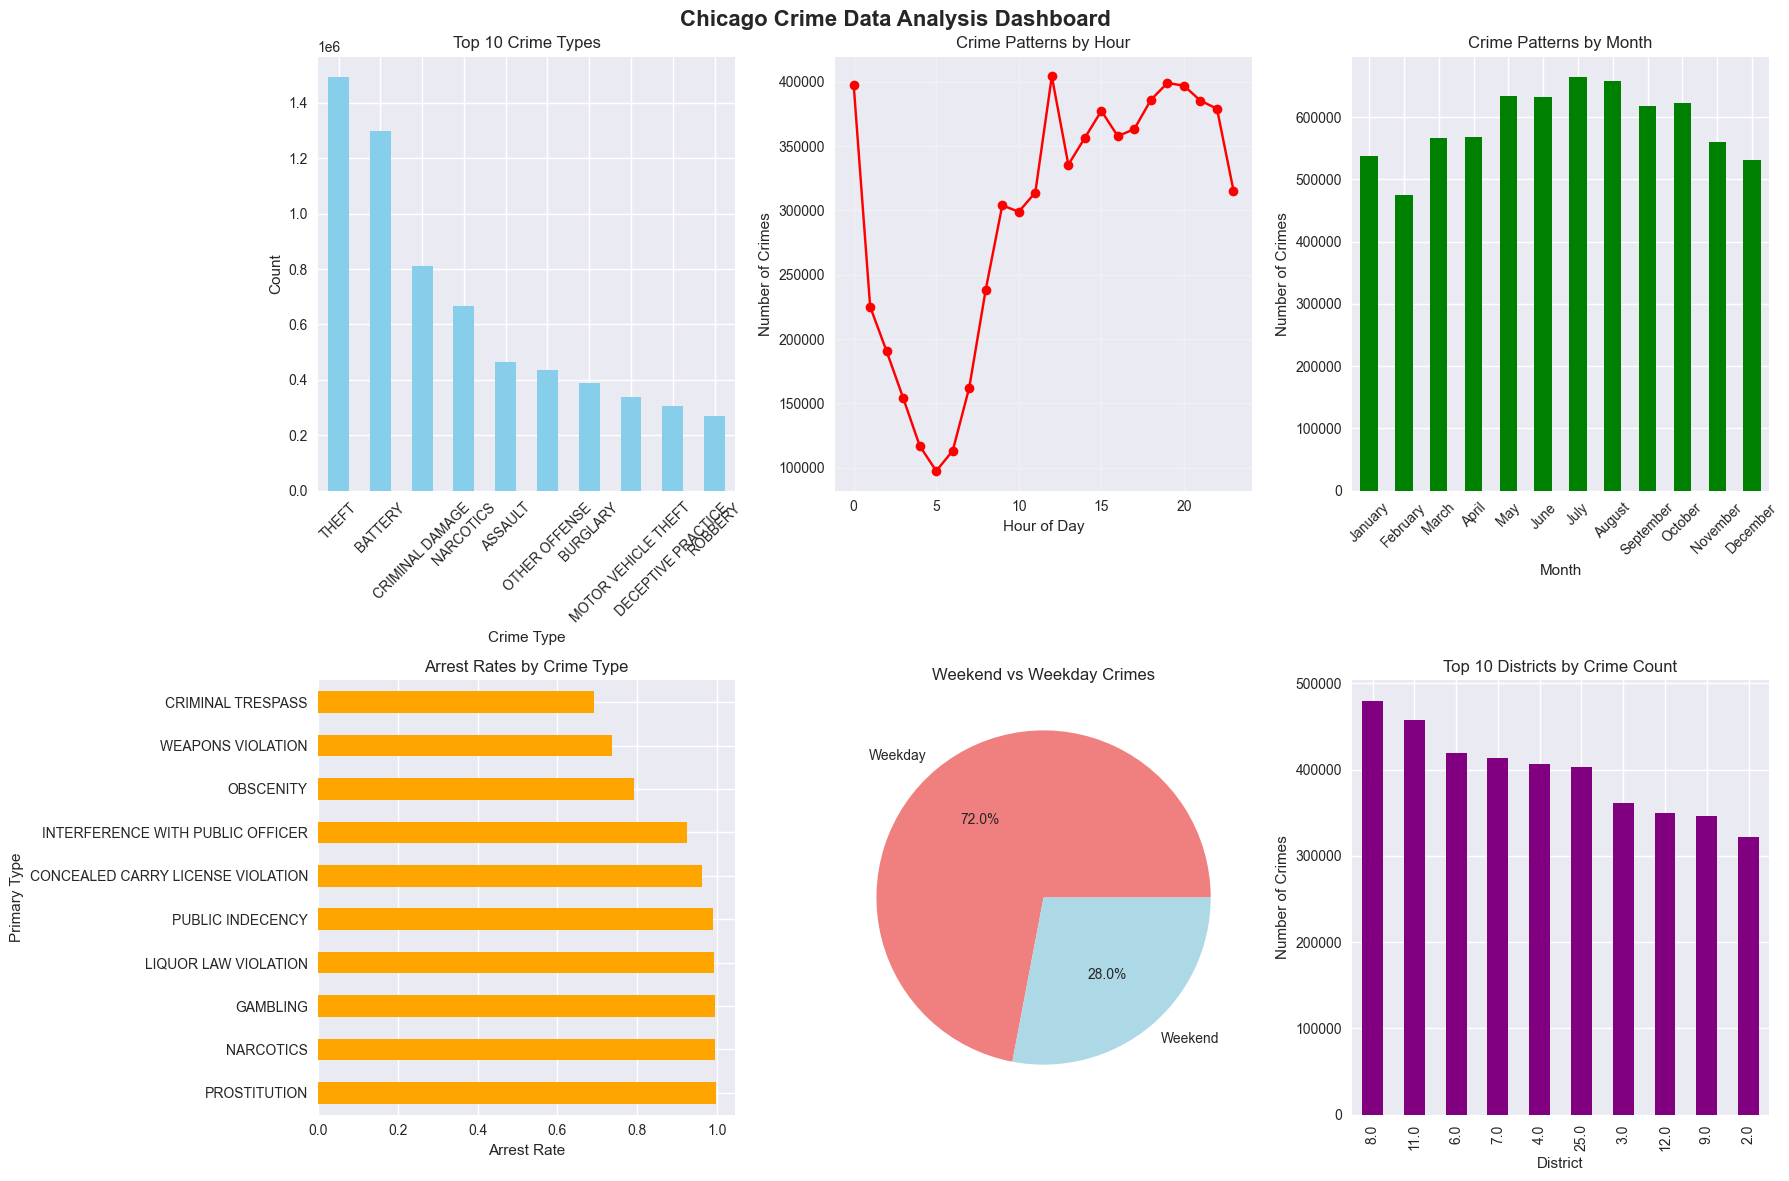

In [50]:
create_crime_visualizations(df_clean)

**Geographic Visualizations**

In [51]:
# def create_geographic_visualizations(df):
    
#     import matplotlib.pyplot as plt
#     from scipy.stats import gaussian_kde
    
#     """Create geographic visualizations"""
    
#     # 1. Crime density by coordinates
#     plt.figure(figsize=(12, 10))
    
#     # Create scatter plot of crime locations
#     plt.scatter(df['Longitude'], df['Latitude'], alpha=0.8, s=2)
#     plt.title('Geographic Distribution of Crimes in Chicago', fontsize=14, fontweight='bold')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
    
#     # Add density information
    
#     # Calculate density
#     xy = np.vstack([df['Longitude'], df['Latitude']])
#     density = gaussian_kde(xy)(xy)
    
#     # Sort points by density
#     idx = density.argsort()
#     longitude_sorted, latitude_sorted, density_sorted = df['Longitude'].iloc[idx], df['Latitude'].iloc[idx], density[idx]
    
#     plt.scatter(longitude_sorted, latitude_sorted, c=density_sorted, s=2, alpha=0.8, cmap='inferno')# cmap = 'viridis','inferno','plasma','magma','cividis','coolwarm','twilight','twilight_shifted, etc
#     plt.colorbar(label='Crime Density')
#     plt.tight_layout()
#     plt.show()
    
#     # 2. District-wise crime analysis
#     plt.figure(figsize=(15, 8))
    
#     district_analysis = df.groupby('District').agg({
#         'ID': 'count',
#         'Arrest': 'mean',
#         'Domestic': 'mean'
#     }).round(3)
    
#     # Create subplots for district analysis
#     fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
#     # Crime count by district
#     district_analysis['ID'].plot(kind='bar', ax=ax1, color='skyblue')
#     ax1.set_title('Total Crimes by District')
#     ax1.set_xlabel('District')
#     ax1.set_ylabel('Number of Crimes')
    
#     # Arrest rate by district
#     district_analysis['Arrest'].plot(kind='bar', ax=ax2, color='orange')
#     ax2.set_title('Arrest Rate by District')
#     ax2.set_xlabel('District')
#     ax2.set_ylabel('Arrest Rate')
    
#     # Domestic violence rate by district
#     district_analysis['Domestic'].plot(kind='bar', ax=ax3, color='red')
#     ax3.set_title('Domestic Violence Rate by District')
#     ax3.set_xlabel('District')
#     ax3.set_ylabel('Domestic Violence Rate')
    
#     plt.tight_layout()
#     plt.show()

In [52]:
#create_geographic_visualizations(df_clean)

NameError: name 'create_geographic_visualizations' is not defined

**Crime Prevention Analysis**

In [53]:
def crime_prevention_analysis(df):
    
    """Analyze factors that could help in crime prevention"""
    
    print("=== CRIME PREVENTION ANALYSIS ===")
    
    # 1. Identify high-risk time periods
    print("1. HIGH-RISK TIME ANALYSIS:")
    
    risk_analysis = df.groupby(['Hour', 'Day_Name']).agg({
        'ID': 'count',
        'Arrest': 'mean'
    }).round(3)
    risk_analysis.columns = ['Crime_Count', 'Arrest_Rate']
    
    # Find highest risk periods (high crime, low arrest rate)
    risk_analysis['Risk_Score'] = risk_analysis['Crime_Count'] / (risk_analysis['Arrest_Rate'] + 0.01)  # Avoid division by zero
    high_risk_periods = risk_analysis.nlargest(10, 'Risk_Score')
    
    print("Top 10 high-risk periods (high crime, low arrest rate):")
    print(high_risk_periods)
    
    # 2. Location-based prevention opportunities
    print("\n2. LOCATION-BASED PREVENTION:")
    
    location_prevention = df.groupby('Location Description').agg({
        'ID': 'count',
        'Arrest': 'mean',
        'Domestic': 'mean'
    }).round(3)
    location_prevention.columns = ['Crime_Count', 'Arrest_Rate', 'Domestic_Rate']
    
    # Focus on locations with high crime but low arrest rates
    prevention_targets = location_prevention[
        (location_prevention['Crime_Count'] > location_prevention['Crime_Count'].quantile(0.7)) &
        (location_prevention['Arrest_Rate'] < location_prevention['Arrest_Rate'].median())
    ].sort_values('Crime_Count', ascending=False)
    
    print("Locations needing enhanced security (high crime, low arrests):")
    print(prevention_targets.head(10))
    
    # 3. Seasonal prevention planning
    print("\n3. SEASONAL PREVENTION PLANNING:")
    
    seasonal_crimes = df.groupby(['Month_Name', 'Primary Type']).size().unstack(fill_value=0)
    
    # Identify crimes that peak in specific months
    monthly_peaks = {}
    for crime_type in seasonal_crimes.columns:
        peak_month = seasonal_crimes[crime_type].idxmax()
        peak_value = seasonal_crimes[crime_type].max()
        monthly_peaks[crime_type] = (peak_month, peak_value)
    
    print("Crime types and their peak months:")
    for crime, (month, count) in sorted(monthly_peaks.items(), key=lambda x: x[1][1], reverse=True)[:10]:
        print(f"{crime}: {month} ({count} incidents)")
    
    return high_risk_periods, prevention_targets, monthly_peaks

In [54]:
prevention_data = crime_prevention_analysis(df_clean)
high_risk_periods, prevention_targets, monthly_peaks = prevention_data

=== CRIME PREVENTION ANALYSIS ===
1. HIGH-RISK TIME ANALYSIS:
Top 10 high-risk periods (high crime, low arrest rate):
                Crime_Count  Arrest_Rate     Risk_Score
Hour Day_Name                                          
0    Monday           56511        0.172  310500.000000
     Sunday           63709        0.200  303376.190476
     Friday           55500        0.185  284615.384615
9    Monday           46899        0.155  284236.363636
0    Saturday         63296        0.217  278837.004405
     Tuesday          52969        0.185  271635.897436
     Thursday         52629        0.185  269892.307692
9    Tuesday          47191        0.170  262172.222222
0    Wednesday        53200        0.194  260784.313725
9    Wednesday        47439        0.181  248371.727749

2. LOCATION-BASED PREVENTION:
Locations needing enhanced security (high crime, low arrests):
                                Crime_Count  Arrest_Rate  Domestic_Rate
Location Description                        

**Resource Allocation Optimization**

In [55]:
def resource_allocation_analysis(df):
    """Analyze optimal police resource allocation"""
    
    print("=== RESOURCE ALLOCATION ANALYSIS ===")
    
    # 1. District workload analysis
    print("1. DISTRICT WORKLOAD ANALYSIS:")
    
    district_workload = df.groupby('District').agg({
        'ID': 'count',
        'Arrest': ['count', 'mean'],
        'Domestic': 'mean',
        'Primary Type': 'nunique'
    }).round(3)
    
    district_workload.columns = ['Total_Crimes', 'Total_Arrests', 'Arrest_Rate', 'Domestic_Rate', 'Crime_Diversity']
    district_workload['Crimes_per_Arrest'] = (district_workload['Total_Crimes'] / 
                                             district_workload['Total_Arrests']).round(2)
    
    # Identify districts needing more resources
    high_workload_districts = district_workload[
        (district_workload['Total_Crimes'] > district_workload['Total_Crimes'].quantile(0.75)) |
        (district_workload['Crimes_per_Arrest'] > district_workload['Crimes_per_Arrest'].quantile(0.75))
    ].sort_values('Total_Crimes', ascending=False)
    
    print("Districts with highest workload:")
    print(high_workload_districts)
    
    # 2. Shift optimization
    print("\n2. SHIFT OPTIMIZATION:")
    
    hourly_demand = df.groupby('Hour').agg({
        'ID': 'count',
        'Arrest': 'mean'
    }).round(3)
    hourly_demand.columns = ['Crime_Count', 'Arrest_Rate']
    
    # Calculate resource needs based on crime volume and complexity
    hourly_demand['Resource_Need'] = (hourly_demand['Crime_Count'] * 
                                     (1 + hourly_demand['Arrest_Rate'])).round(2)
    
    print("Hourly resource needs (considering crime volume and arrest complexity):")
    print(hourly_demand.sort_values('Resource_Need', ascending=False))
    
    # 3. Specialized unit deployment
    print("\n3. SPECIALIZED UNIT DEPLOYMENT:")
    
    specialized_needs = df.groupby(['Primary Type', 'Location Description']).agg({
        'ID': 'count',
        'Arrest': 'mean',
        'Domestic': 'mean'
    }).round(3)
    
    specialized_needs.columns = ['Crime_Count', 'Arrest_Rate', 'Domestic_Rate']
    
    # Identify scenarios requiring specialized units
    domestic_violence_focus = specialized_needs[
        specialized_needs['Domestic_Rate'] > 0.5
    ].sort_values('Crime_Count', ascending=False)
    
    print("Top scenarios for domestic violence specialized units:")
    print(domestic_violence_focus.head(10))
    
    return district_workload, hourly_demand, specialized_needs

In [56]:
resource_data = resource_allocation_analysis(df_clean)
district_workload, hourly_demand, specialized_needs = resource_data

=== RESOURCE ALLOCATION ANALYSIS ===
1. DISTRICT WORKLOAD ANALYSIS:
Districts with highest workload:
          Total_Crimes  Total_Arrests  Arrest_Rate  Domestic_Rate  Crime_Diversity  Crimes_per_Arrest
District                                                                                             
8.0             479306         479306        0.225          0.145               33                1.0
11.0            457597         457597        0.415          0.154               35                1.0
6.0             419384         419384        0.257          0.191               33                1.0
7.0             412834         412834        0.280          0.201               32                1.0
4.0             406672         406672        0.224          0.160               34                1.0
25.0            403259         403259        0.270          0.157               33                1.0

2. SHIFT OPTIMIZATION:
Hourly resource needs (considering crime volume and arrest 

**Crime Trend Forecasting**

In [57]:
def crime_forecasting_analysis(df):
    """Analyze trends for forecasting purposes"""
    
    print("=== CRIME FORECASTING ANALYSIS ===")
    
    # 1. Long-term trend analysis
    print("1. LONG-TERM TRENDS:")
    
    yearly_trends = df.groupby(['Year', 'Primary Type']).size().unstack(fill_value=0)
    
    # Calculate year-over-year change rates
    trend_analysis = {}
    for crime_type in yearly_trends.columns:
        if len(yearly_trends[crime_type]) > 1:
            # Calculate average year-over-year change
            changes = yearly_trends[crime_type].pct_change().dropna()
            avg_change = changes.mean()
            trend_direction = 'Increasing' if avg_change > 0.05 else 'Decreasing' if avg_change < -0.05 else 'Stable'
            trend_analysis[crime_type] = {
                'avg_change': avg_change,
                'direction': trend_direction,
                'recent_count': yearly_trends[crime_type].iloc[-1]
            }
    
    # Sort by most significant trends
    sorted_trends = sorted(trend_analysis.items(), 
                          key=lambda x: abs(x[1]['avg_change']), 
                          reverse=True)
    
    print("Crime types with most significant trends:")
    for crime_type, data in sorted_trends[:10]:
        print(f"{crime_type}: {data['direction']} ({data['avg_change']:.1%} avg change)")
    
    # 2. Seasonal forecasting components
    print("\n2. SEASONAL PATTERNS FOR FORECASTING:")
    
    monthly_patterns = df.groupby(['Month', 'Primary Type']).size().unstack(fill_value=0)
    
    # Calculate seasonal indices for top crime types
    top_crimes = df['Primary Type'].value_counts().head(5).index
    seasonal_indices = {}
    
    for crime_type in top_crimes:
        if crime_type in monthly_patterns.columns:
            monthly_avg = monthly_patterns[crime_type].mean()
            seasonal_index = (monthly_patterns[crime_type] / monthly_avg).round(2)
            peak_month = seasonal_index.idxmax()
            low_month = seasonal_index.idxmin()
            
            seasonal_indices[crime_type] = {
                'peak_month': peak_month,
                'peak_index': seasonal_index.max(),
                'low_month': low_month,
                'low_index': seasonal_index.min(),
                'seasonality_strength': seasonal_index.std()
            }
    
    print("Seasonal patterns for forecasting:")
    for crime_type, data in seasonal_indices.items():
        print(f"{crime_type}:")
        print(f"  Peak: Month {data['peak_month']} (index: {data['peak_index']})")
        print(f"  Low: Month {data['low_month']} (index: {data['low_index']})")
        print(f"  Seasonality strength: {data['seasonality_strength']:.2f}")
        print()
    
    # 3. Leading indicators
    print("3. POTENTIAL LEADING INDICATORS:")
    
    # Analyze if certain crime types predict others
    monthly_crime_data = df.groupby([df['Date'].dt.to_period('M'), 'Primary Type']).size().unstack(fill_value=0)
    
    # Calculate correlations between crime types (with lag)
    correlations = monthly_crime_data.corr()
    
    print("Strong correlations between crime types (potential leading indicators):")
    for crime1 in correlations.columns[:5]:  # Limit output
        corr_series = correlations[crime1].drop(crime1).abs().sort_values(ascending=False)
        if len(corr_series) > 0:
            strongest_corr = corr_series.iloc[0]
            if strongest_corr > 0.7:  # Strong correlation
                print(f"{crime1} ↔ {corr_series.index[0]}: {strongest_corr:.2f}")
    
    return yearly_trends, seasonal_indices, correlations

In [58]:
forecasting_data = crime_forecasting_analysis(df_clean)
yearly_trends, seasonal_indices, correlations = forecasting_data

=== CRIME FORECASTING ANALYSIS ===
1. LONG-TERM TRENDS:
Crime types with most significant trends:
CONCEALED CARRY LICENSE VIOLATION: Increasing (inf% avg change)
HUMAN TRAFFICKING: Increasing (inf% avg change)
NON - CRIMINAL: Increasing (inf% avg change)
NON-CRIMINAL: Increasing (inf% avg change)
NON-CRIMINAL (SUBJECT SPECIFIED): Increasing (inf% avg change)
OBSCENITY: Increasing (inf% avg change)
OTHER NARCOTIC VIOLATION: Increasing (inf% avg change)
PUBLIC INDECENCY: Increasing (inf% avg change)
RITUALISM: Increasing (inf% avg change)
STALKING: Increasing (inf% avg change)

2. SEASONAL PATTERNS FOR FORECASTING:
Seasonal patterns for forecasting:
THEFT:
  Peak: Month 7 (index: 1.19)
  Low: Month 2 (index: 0.76)
  Seasonality strength: 0.13

BATTERY:
  Peak: Month 7 (index: 1.18)
  Low: Month 2 (index: 0.78)
  Seasonality strength: 0.14

CRIMINAL DAMAGE:
  Peak: Month 7 (index: 1.15)
  Low: Month 2 (index: 0.73)
  Seasonality strength: 0.13

NARCOTICS:
  Peak: Month 3 (index: 1.06)
  L

**Using Advanced Pandas Techniques**

In [59]:
def advanced_aggregation_techniques(df):
    
    
    print("=== ADVANCED AGGREGATION TECHNIQUES ===")
    
    # 1. Custom aggregation functions
    def crime_severity_score(arrests):
        """Custom function to calculate crime severity based on arrest rates"""
        if len(arrests) == 0:
            return 0
        return len(arrests) * arrests.mean() * 100  # Volume × Success Rate × 100
    
    def peak_hour_range(hours):
        """Find the 4-hour period with most crimes"""
        if len(hours) == 0:
            return "Unknown"
        hour_counts = pd.Series(hours).value_counts()
        peak_hour = hour_counts.index[0]
        return f"{peak_hour}-{(peak_hour + 3) % 24}"
    
    # Apply custom aggregations
    district_analysis = df.groupby('District').agg({
        'Arrest': crime_severity_score,
        'Hour': peak_hour_range,
        'Primary Type': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown',
        'Domestic': ['sum', 'mean'],
        'ID': 'count'
    }).round(2)
    
    # Flatten column names
    district_analysis.columns = ['Severity_Score', 'Peak_Hours', 'Most_Common_Crime', 
                               'Domestic_Count', 'Domestic_Rate', 'Total_Crimes']
    
    print("District Analysis with Custom Aggregations:")
    print(district_analysis.head(10))
    
    # 2. Rolling window analysis
    print("\n=== ROLLING WINDOW ANALYSIS ===")
    
    daily_crimes = df.groupby(df['Date'].dt.date).size()
    daily_crimes.index = pd.to_datetime(daily_crimes.index)
    
    # Multiple rolling windows
    rolling_analysis = pd.DataFrame({
        'Daily_Crimes': daily_crimes,
        'Weekly_Average': daily_crimes.rolling(window=7).mean(),
        'Monthly_Average': daily_crimes.rolling(window=30).mean(),
        'Weekly_Std': daily_crimes.rolling(window=7).std(),
        'Anomaly_Score': abs(daily_crimes - daily_crimes.rolling(window=30).mean()) / daily_crimes.rolling(window=30).std()
    })
    
    # Find anomalous days
    anomalous_days = rolling_analysis[rolling_analysis['Anomaly_Score'] > 2].sort_values('Anomaly_Score', ascending=False)
    print("Top 5 anomalous crime days:")
    print(anomalous_days.head())
    
    # 3. Conditional aggregations
    print("\n=== CONDITIONAL AGGREGATIONS ===")
    
    # Different statistics based on conditions
    conditional_stats = df.groupby('Primary Type').apply(
        lambda group: pd.Series({
            'Total_Cases': len(group),
            'High_Crime_Districts': len(group[group['District'].isin([1, 2, 3])]),
            'Weekend_Rate': group['Is_Weekend'].mean(),
            'Night_Crimes': len(group[group['Hour'].between(22, 6)]),
            'Arrest_Rate_Domestic': group[group['Domestic']]['Arrest'].mean() if group['Domestic'].any() else 0,
            'Arrest_Rate_Non_Domestic': group[~group['Domestic']]['Arrest'].mean() if (~group['Domestic']).any() else 0
        })
    ).round(3)
    
    print("Conditional statistics by crime type:")
    print(conditional_stats.head())


In [60]:
advanced_aggregation_techniques(df_clean)


=== ADVANCED AGGREGATION TECHNIQUES ===
District Analysis with Custom Aggregations:
          Severity_Score Peak_Hours Most_Common_Crime  Domestic_Count  Domestic_Rate  Total_Crimes
District                                                                                          
1.0            7832100.0      12-15             THEFT           14156           0.05        290872
2.0            7928100.0      12-15             THEFT           44238           0.14        321880
3.0            9161900.0      19-22           BATTERY           75004           0.21        361056
4.0            9096300.0      12-15           BATTERY           64914           0.16        406672
5.0            7953000.0      12-15           BATTERY           61577           0.19        316183
6.0           10798500.0        0-3           BATTERY           80128           0.19        419384
7.0           11548200.0      20-23           BATTERY           83156           0.20        412834
8.0           10782200.0 

In [61]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude', 'Location', 'Month', 'Day', 'Hour', 'Day_of_Week', 'Day_Name', 'Month_Name', 'Quarter', 'Is_Weekend', 'Time_Period'], dtype='object')

In [62]:
location_counts = df['Block'].value_counts()
repeat_locations = location_counts[location_counts >= 0].index

repeat_location_crimes = df[df['Block'].isin(repeat_locations)]

print(f"Crimes at repeat locations (10+ crimes): {len(repeat_location_crimes)}")
print(f"Number of repeat locations: {len(repeat_locations)}")

# Analyze patterns at repeat locations
repeat_patterns = repeat_location_crimes.groupby('Block').agg({
    'Primary Type': lambda x: len(x.unique()),  # Crime diversity
        'Hour': lambda x: x.std(),  # Time variability
        'Arrest': 'mean',
        'ID': 'count'
    }).round(2)

repeat_patterns.columns = ['Crime_Diversity', 'Time_Variability', 'Arrest_Rate', 'Total_Crimes']
repeat_patterns = repeat_patterns.sort_values('Total_Crimes', ascending=False)


Crimes at repeat locations (10+ crimes): 7784664
Number of repeat locations: 62845


In [64]:
def advanced_filtering_techniques(df):
   
    
    print("=== ADVANCED FILTERING TECHNIQUES ===")
    
    # 1. Complex multi-condition filtering with query
    print("1. COMPLEX QUERY FILTERING:")
    
    # Find crimes that are likely to be solved based on multiple factors
    # Option 1: Single line query (recommended)
    high_solve_probability = df.query("`Primary Type` in ['THEFT', 'BATTERY', 'ASSAULT'] and `Location Description` in ['STREET', 'RESIDENCE', 'APARTMENT'] and Domestic == True and Hour >= 18 and Hour <= 23")
    
    # Option 2: Traditional filtering (more readable for complex conditions)
    if len(high_solve_probability) == 0:
        # Fallback to traditional filtering if query doesn't match any records
        high_solve_probability = df[
            (df['Primary Type'].isin(['THEFT', 'BATTERY', 'ASSAULT'])) & 
            (df['Location Description'].isin(['STREET', 'RESIDENCE', 'APARTMENT'])) & 
            (df['Domestic'] == True) & 
            (df['Hour'].between(18, 23))
        ]
    
    print(f"High solve probability crimes: {len(high_solve_probability)}")
    if len(high_solve_probability) > 0:
        print(f"Actual arrest rate: {high_solve_probability['Arrest'].mean():.2%}")
    else:
        print("No crimes match the specified criteria")
    
    # 2. Dynamic filtering based on percentiles
    print("\n2. PERCENTILE-BASED FILTERING:")
    
    # Find districts with crime rates in top 25% but arrest rates in bottom 25%
    district_stats = df.groupby('District').agg({
        'ID': 'count',
        'Arrest': 'mean'
    })
    
    crime_threshold = district_stats['ID'].quantile(0.75)
    arrest_threshold = district_stats['Arrest'].quantile(0.25)
    
    problem_districts = district_stats[
        (district_stats['ID'] >= crime_threshold) & 
        (district_stats['Arrest'] <= arrest_threshold)
    ]
    
    print("Districts with high crime but low arrest rates:")
    print(problem_districts)
    
    # 3. Time-based complex filtering
    print("\n3. TIME-BASED FILTERING:")
    
    # Find crimes during shift changes (assuming 3 shifts: 7-15, 15-23, 23-7)
    shift_change_hours = [7, 15, 23]
    shift_change_crimes = df[df['Hour'].isin(shift_change_hours)]
    
    print(f"Crimes during shift changes: {len(shift_change_crimes)}")
    print(f"Percentage of total crimes: {len(shift_change_crimes)/len(df)*100:.1f}%")
    
    # 4. Pattern-based filtering
    print("\n4. PATTERN-BASED FILTERING:")
    
    # Find repeat locations (same block with multiple crimes)
    location_counts = df['Block'].value_counts()
    repeat_locations = location_counts[location_counts >= 0].index
    
    repeat_location_crimes = df[df['Block'].isin(repeat_locations)]
    
    print(f"Crimes at repeat locations (10+ crimes): {len(repeat_location_crimes)}")
    print(f"Number of repeat locations: {len(repeat_locations)}")
    
    # Analyze patterns at repeat locations
    repeat_patterns = repeat_location_crimes.groupby('Block').agg({
        'Primary Type': lambda x: len(x.unique()),  # Crime diversity
         'Hour': lambda x: x.std(),  # Time variability
         'Arrest': 'mean',
         'ID': 'count'
     }).round(2)
    
    repeat_patterns.columns = ['Crime_Diversity', 'Time_Variability', 'Arrest_Rate', 'Total_Crimes']
    repeat_patterns = repeat_patterns.sort_values('Total_Crimes', ascending=False)
    
    print("Top repeat crime locations:")
    print(repeat_patterns.head())

In [65]:
advanced_filtering_techniques(df_clean)

=== ADVANCED FILTERING TECHNIQUES ===
1. COMPLEX QUERY FILTERING:
High solve probability crimes: 187436
Actual arrest rate: 20.85%

2. PERCENTILE-BASED FILTERING:
Districts with high crime but low arrest rates:
Empty DataFrame
Columns: [ID, Arrest]
Index: []

3. TIME-BASED FILTERING:
Crimes during shift changes: 854986
Percentage of total crimes: 12.1%

4. PATTERN-BASED FILTERING:
Crimes at repeat locations (10+ crimes): 7068429
Number of repeat locations: 37667
Top repeat crime locations:
                                     Crime_Diversity  Time_Variability  Arrest_Rate  Total_Crimes
Block                                                                                            
001XX N STATE ST                                  25              4.08         0.54         14122
076XX S CICERO AVE                                21              3.69         0.45         10070
008XX N MICHIGAN AVE                              24              3.79         0.39          9355
0000X N STATE S